# Demo Notebook
### A simple example in training GPSSM models.

In [1]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))

import numpy as np
import numpy.random as rnd
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

import gpflow as gp
from gpflow import settings as gps
from GPt import GPSSM_VCDT, GPSSM_FactorizedLinear, PRSSM
from GPt.transitions import KinkTransitions
from GPt.emissions import GaussianEmissions

import matplotlib
import matplotlib.pyplot as plt

import gpflow.training.monitor as mon # EVB

## Global Variables

In [2]:
T = 60 # length of generated trajectory 
x1 = 0.5 # Initial state of generated trajectory
process_noise_std = 0.05
observation_noise_std = 0.2
bool_standardize = False # Standardize observations
maxiter = int(1e5) # Maximum number of iterations for training 

# "Kink" Transition Function
### We will try to learn the transition function shown below, by only looking at noisy data.

In [3]:
state_dim = 1
obs_dim = 1

tr_fn = KinkTransitions(dim=state_dim)
session = tr_fn.enquire_session()

### Let's visualise the transition function and a trajectory:

In [4]:
# Let's see what the function does at these inputs:
X = np.linspace(-3, 1.1, 100)[:, None]
X_tf = tf.constant(X)
F = session.run(tr_fn.conditional_mean(X_tf))

# Let's generate a trajectory from an arbitrary starting point:
def generate_trajectory(T, x1=0., process_noise_std=0.):
    tf_input = tf.placeholder(dtype=gps.float_type, shape=[1,1])
    tf_op = tr_fn.conditional_mean(tf_input)
    traj = np.zeros((T, 1))
    traj[0] = x1
    for t in range(T - 1):
        noise = np.random.randn() * process_noise_std
        feed_dict = {tf_input: traj[[t]]}
        traj[t+1] = session.run(tf_op, feed_dict) + noise
    return traj

traj = generate_trajectory(T=9, x1=0.5)

<IPython.core.display.Javascript object>


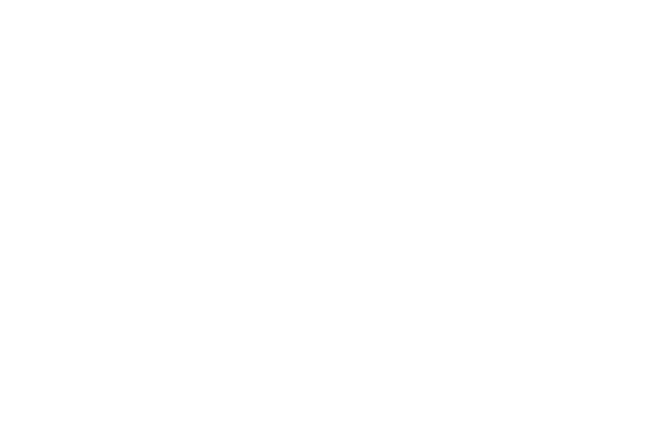

In [5]:
%matplotlib notebook

def plot_trajectory(traj, colmap='viridis', X=X, F=F,
                    title='"Kink" Transition Function'):
    T = len(traj)
    plt.plot(X, F, color='r', zorder=0, alpha=0.7)

    cmap = matplotlib.cm.get_cmap(colmap)
    plt.scatter(traj[0], traj[1], color=cmap(0), zorder=2)
    for i in range(1, T-1):
        plt.plot([traj[i-1,0], traj[i,0]], [traj[i,0], traj[i+1,0]], 
                 color=cmap(i/(T-2)), zorder=1, label='_nolegend_')
        plt.scatter(traj[i], traj[i+1], color=cmap(i/(T-2)), zorder=2)

    mappable = matplotlib.cm.ScalarMappable(
        norm=matplotlib.colors.Normalize(1, T-1), cmap=cmap)
    mappable.set_array(np.linspace(0, 1, T-1))
    plt.colorbar(mappable, ax=plt.gca(), label='transition index')

    plt.title(title)
    plt.xlabel('$x_t$')
    plt.ylabel('$x_{t+1}$')
    plt.legend(['Transition Function', 'Initial Transition'])


plt.figure(figsize=(6,4))
plot_trajectory(traj)
plt.show()

### Let's generate some new, noisy data to train our model:
Notice that there are two kinds of noise: "process" noise and "observation" noise.
Process noise is added to the latent state before each transition, whereas 
observation noise is added to the latent states to produce the observations.

In [6]:
rnd.seed(0)
latents = generate_trajectory(T=T, x1=x1, process_noise_std=process_noise_std)
observations = latents + np.random.randn(T, state_dim) * observation_noise_std

## EVB

In [7]:
def standardize(xtrain, xval=None, xtest=None):
    """
    Standarsdize data to have zero-mean and unit variance across datapoints, and time
    :param xtrain: (N, T, D)
    :param xval:
    :param xtest:
    :return:
    """
    mean_X = xtrain.mean(axis=(0, 1))
    std_X = xtrain.std(axis=(0, 1))

    xtrain -= mean_X  # operations in place
    xtrain /= std_X

    if xval is not None:
        xval -= mean_X
        xval /= std_X

    if xtest is not None:
        xtest -= mean_X
        xtest /= std_X

    return mean_X, std_X


In [8]:
def unstandardize(x, mean_X, std_X):
    """
    Reverse standardization tranform
    :param x:
    :param mean_X:
    :param std_X:
    :return:
    """
    x *= std_X
    x += mean_X


In [9]:
if (bool_standardize): 
    mean_X, std_X = standardize(observations)

## Original

<IPython.core.display.Javascript object>


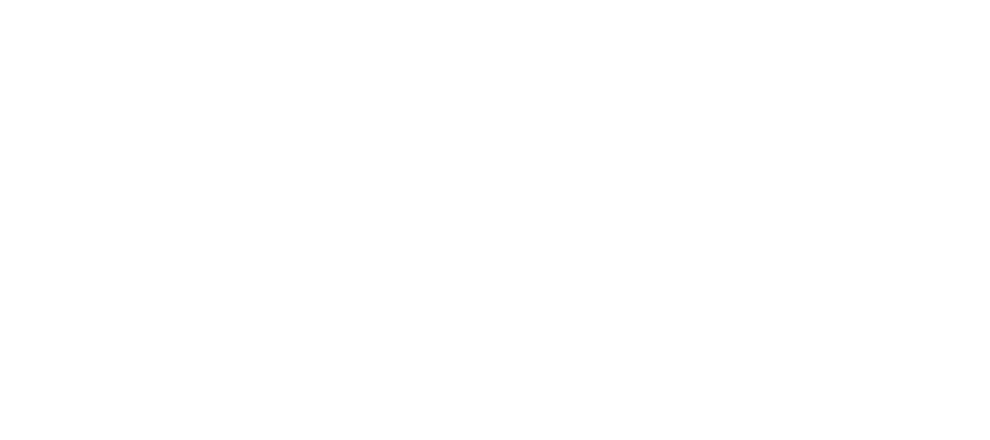

In [10]:
%matplotlib notebook
fig, ax = plt.subplots(1, 2, figsize=(9,4))
ax[0].plot(latents, 'r-o')
ax[0].plot(observations, 'k-o')
ax[0].legend(['Latent States', 'Noisy Observations'], loc='lower left')
ax[0].set_xlabel('time-step')
plot_trajectory(observations, title=None)
fig.suptitle('A Noisy Trajectory')
plt.show()

## Model Initialisation
### The initialisation arguments below are the ones shared by all GPSSM models.
Multiple sequence models have special arguments to specify mini-batching over independent sequences and whether the posterior of long sequences should be "chunked" up to break dependence and make cubic sampling tractable.

All models have `Z, Umu, Ucov_chol` as variational parameters for the GP posterior.

The `GPSSM_FactorizedLinear` model parameterises the joint Gaussian variational posterior over states with `Xmu, Xcov`.

All other models parameterise the Gaussian posterior transitions using `As, bs, Ss`, and `qx1_mu, qx1_cov` for the initial state posterior.

All covariances are internally represented and optimised by their Cholesky decomposition (their variable names end in `chol`).

In [11]:
param_dict = {
    
# Required arguments:
    
    'latent_dim': state_dim,  # latent dimensionality of the data
    'Y': observations,  # the observed sequence (i.e. the data)
    
# Optional arguments and default values: 
    
    'inputs': None,  # control inputs (if any)
    'emissions': None,  # the emission model (default: linear transformation plus Gaussian noise)
    'px1_mu': None,  # the Gaussian's prior mean for the initial latent state (default: 0)
    'px1_cov': None,  # the Gaussian's prior covariance for the initial 
                      # latent state (default: identity)
    'kern': None,  # the Gaussian process' kernel (default: Matern 3/2 kernel)
    'Z': None,  # the inducing inputs (default: standard normal samples)
    'n_ind_pts': 100,  # the number of inducing points (ignored if Z is given)
    'mean_fn': None,  # the Gaussian process' mean function (default: the identity function)
    'Q_diag': None,  # the diagonal of the Gaussian process noise's covariance matrix (default: 1)
    'Umu': None,  # the mean of the Gaussian posterior over inducing outputs (default: 0)
    'Ucov_chol': None,  # Cholesky of the covariance matrix of the Gaussian 
                        # posterior over inducing outputs (default: identity - whitening in use)
    'n_samples': 100,  # number of samples from the posterior with which we will compute the ELBO
    'seed': None,  # random seed for the samples
    'jitter': gps.numerics.jitter_level,  # amount of jitter to be added to the kernel matrix
    'name': None  # the name of the initialised model in the tensorflow graph
}

### Let's set some parameters appropriately for the task:

In [12]:
param_dict['Z'] = observations.copy()
param_dict['mean_fn'] = gp.mean_functions.Zero()

# Let's also initialise and fix the observation model to the true one.
# We don't want to learn this here since there's too little data and scale invariances 
# between the GP kernel and the emission's linear transformation. We fix it to the identity
# plus Gaussian noise:
obs_noise_covariance = np.eye(obs_dim) * (observation_noise_std ** 2.)
emissions = GaussianEmissions(
    obs_dim=obs_dim,
    R=obs_noise_covariance)

emissions.trainable = False
param_dict['emissions'] = emissions

### and build the models:

In [13]:
# The inference method proposed by Ialongo et al. (2019) - ICML
vcdt = GPSSM_VCDT(**param_dict)

# The factorised, joint Gaussian GPSSM outlined
# in McHutchon (2014) - PhD Thesis: mlg.eng.cam.ac.uk/pub/pdf/Mch14.pdf
factlin = GPSSM_FactorizedLinear(**param_dict)

# The inference method proposed by Doerr et al. (2018) - ICML
prssm = PRSSM(**param_dict)

## Monitor Tasks (EVB)

In [14]:
file_writer = mon.LogdirWriter('./model-tensorboard')

saver_task = mon.CheckpointTask('./monitor-saves').with_name('saver')\
    .with_condition(mon.PeriodicIterationCondition(1000))\
    .with_exit_condition(True)


model_tboard_task = mon.ModelToTensorBoardTask(file_writer, vcdt, only_scalars=False).with_name('model_tboard')\
    .with_condition(mon.PeriodicIterationCondition(100))\
    .with_exit_condition(True)

## Model Fitting

### Let's define an optimisation method:

In [15]:
optimizer = gp.train.AdamOptimizer()

### and minimise our objective (i.e. the negative of the lower bound on the marginal likelihood):
#### To track training with `tensorboard` I highly recommend using GPflow's `monitor` module.

In [16]:
session = vcdt.enquire_session()
global_step = mon.create_global_step(session)

monitor_tasks = [model_tboard_task, saver_task]
monitor = mon.Monitor(monitor_tasks, session, global_step)

In [17]:
if os.path.isdir('./monitor-saves'):
    mon.restore_session(session, './monitor-saves')

In [18]:
#%%time
#optimizer.minimize(vcdt, maxiter=maxiter)
#print('Value of the variational lower bound for VCDT:', 
#      vcdt.compute_log_likelihood(), '\n')
# EVB
with mon.Monitor(monitor_tasks, session, global_step, print_summary=True) as monitor:
    optimizer.minimize(vcdt, step_callback=monitor, maxiter=maxiter, global_step=global_step)

file_writer.close()

Tasks execution time summary:
model_tboard:	21.2733 (sec)
saver:	34.5419 (sec)


In [19]:
%%time
optimizer.minimize(factlin, maxiter=maxiter)
print('Value of the variational lower bound for Factorized-Linear method:', 
      factlin.compute_log_likelihood(), '\n')

Value of the variational lower bound for Factorized-Linear method: -48.3611928027489 

CPU times: user 1h 36min 6s, sys: 34min 52s, total: 2h 10min 58s
Wall time: 35min 34s


In [20]:
%%time
optimizer.minimize(prssm, maxiter=maxiter)
print('Value of the variational lower bound for PR-SSM:', 
      prssm.compute_log_likelihood(), '\n')

Value of the variational lower bound for PR-SSM: -959.789192630171 

CPU times: user 6h 6min 20s, sys: 1h 47min 52s, total: 7h 54min 13s
Wall time: 2h 29min 47s


## Visualising model fit

### GP predictions:

In [21]:
if bool_standardize: 
    X_tf = (X_tf - mean_X)/std_X

In [22]:
F_mu_vcdt, F_var_vcdt = session.run(vcdt._build_predict_f(X_tf))

F_mu_factlin, F_var_factlin = session.run(
    factlin.transitions.conditional(X_tf, add_noise=False))

F_mu_prssm, F_var_prssm = session.run(prssm._build_predict_f(X_tf))

## EVB

In [23]:
if bool_standardize: 
    F_mu_vcdt = mean_X + std_X * F_mu_vcdt
    F_var_vcdt = std_X**2 * F_var_vcdt

    F_mu_factlin = mean_X + std_X * F_mu_factlin
    F_var_factlin = std_X**2 * F_var_factlin

    F_mu_prssm = mean_X + std_X * F_mu_prssm
    F_var_prssm = std_X**2 * F_var_prssm

## EVB

In [24]:
Z_vcdt = vcdt.Z.feat.Z.value
Z_factlin = factlin.transitions.Z.feat.Z.value
Z_prssm = prssm.Z.feat.Z.value

In [25]:
if bool_standardize:
    observations = mean_X + std_X * observations

In [26]:
if bool_standardize:
    Z_vcdt = mean_X + std_X * Z_vcdt    
    Z_factlin = mean_X + std_X * Z_factlin
    Z_prssm = mean_X + std_X * Z_prssm

### Plotting:

<IPython.core.display.Javascript object>


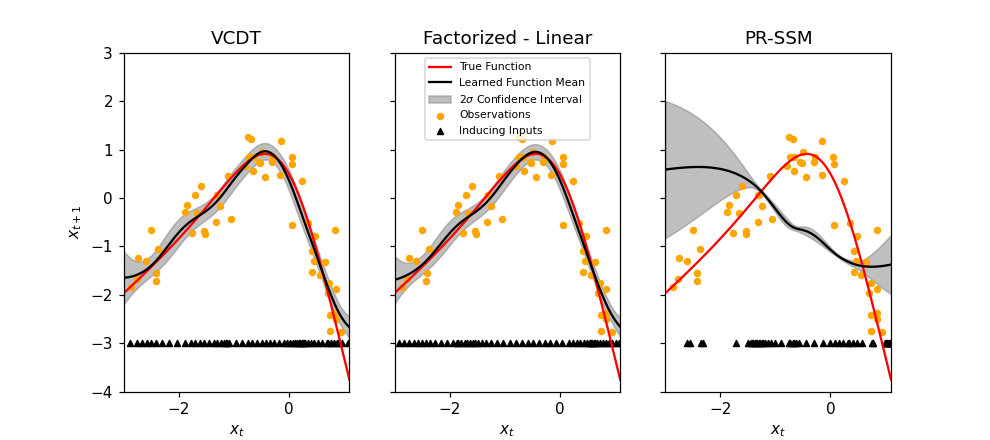

In [28]:
%matplotlib notebook
fig, ax = plt.subplots(1, 3, figsize=(9,4), sharex=True, sharey=True)

sigmas = 2  # how many standard deviations to show 

def plot_learned_function(ax, F_mu, F_var, Z):
    ax.fill_between(
        X[:, 0], 
        F_mu[:, 0] - sigmas*(F_var[:, 0]**0.5), 
        F_mu[:, 0] + sigmas*(F_var[:, 0]**0.5), 
        color='gray', alpha=0.5)
    
    ax.plot(X, F, 'r')
    ax.plot(X, F_mu, 'k')

    ax.scatter(observations[:-1, 0], observations[1:, 0], 
               s=15, color='orange')
    
    ax.scatter(Z[:, 0], np.zeros(len(Z)) - 3, 
               s=15, marker='^', color='k')

    ax.set_xlabel('$x_t$')
    ax.set_xlim(X.min(), X.max())
    ax.set_ylim(-4, 3)

plot_learned_function(ax[0], F_mu_vcdt, F_var_vcdt, 
                      Z_vcdt)
plot_learned_function(ax[1], F_mu_factlin, F_var_factlin, 
                      Z_factlin)
plot_learned_function(ax[2], F_mu_prssm, F_var_prssm, 
                      Z_prssm)

ax[0].set_ylabel('$x_{t+1}$')
ax[1].legend(['True Function', 
              'Learned Function Mean', 
              '${}\sigma$ Confidence Interval'.format(sigmas), 
              'Observations', 
              'Inducing Inputs'],
             loc='upper center',
             prop={'size': 7})

ax[0].set_title('VCDT')
ax[1].set_title('Factorized - Linear')
ax[2].set_title('PR-SSM')
plt.show()